In [175]:
import torch
import os
import torch
from torch import nn
from torch.nn.functional import relu
from mne.io import read_raw_edf
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class ResidualBlock(nn.Module):
    def __init__(self,in_feature_maps,out_feature_maps,n_features) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_feature_maps,out_feature_maps,kernel_size=8,padding='same',bias=False)
        self.bn1 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c2 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=5,padding='same',bias=False)
        self.bn2 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c3 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=3,padding='same',bias=False)
        self.bn3 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

        self.c4 = nn.Conv1d(in_feature_maps,out_feature_maps,1,padding='same',bias=False)
        self.bn4 = nn.LayerNorm((out_feature_maps,n_features),elementwise_affine=False)

    def forward(self,x):
        identity = x
        x = self.c1(x)
        x = self.bn1(x)
        x = relu(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = relu(x)

        x = self.c3(x)
        x = self.bn3(x)
        x = relu(x)

        identity = self.c4(identity)
        identity = self.bn4(identity)

        x = x+identity
        x = relu(x)
        
        return x
    
class Frodo(nn.Module):
    def __init__(self,n_features) -> None:
        super().__init__()
        self.n_features = n_features
        self.block1 = ResidualBlock(1,8,n_features)
        self.block2 = ResidualBlock(8,16,n_features)
        self.block3 = ResidualBlock(16,16,n_features)

        self.gap = nn.AvgPool1d(kernel_size=n_features)
        self.fc1 = nn.Linear(in_features=16,out_features=3)
    def forward(self,x,classification=True):
        x = x.view(-1,1,self.n_features)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        if(classification):
            x = self.fc1(x.squeeze())
            return x
        else:
            return x.squeeze()
        
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = []
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x.append(xi.unsqueeze(0))
        x = torch.cat(x)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
    
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self,X):
        self.len = len(X)
        self.X = torch.cat([torch.zeros(4,5000),X,torch.zeros(4,5000)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx:idx+9].flatten()

def score_recording(edf_filename,zdb_filename,model_path,eeg_ch_name,device):
    if not os.path.exists(model_path):
        raise FileExistsError(model_path)

    model = Gandalf()
    model.load_state_dict(torch.load(model_path,map_location='cpu'))

    raw = read_raw_edf(input_fname=f'data/{edf_filename}')
    data = raw.get_data(picks=eeg_ch_name)
    eeg = torch.from_numpy(data[0]).float()
    eeg = eeg.view(-1,5000)

    model.eval()
    model.to(device)

    with torch.no_grad():
        dataloader = DataLoader(EEGDataset(eeg),batch_size=32)
        logits = torch.cat([model(Xi.to(device)).cpu() for Xi in tqdm(dataloader)])
        y_pred = logits.softmax(dim=1).argmax(axis=1)

    pd.DataFrame(y_pred,columns=['y_pred']).to_csv(f"data/{edf_filename.replace('.edf','')}.csv",index=False)
    pd.DataFrame(logits).to_csv(f"data/{edf_filename.replace('.edf','_logits')}.csv",index=False)

In [176]:
import os

data_dir = 'data'
ids  = [file.replace('.edf','') for file in os.listdir(data_dir) if file.endswith('.edf')]
edfs = [file for file in os.listdir(data_dir) if file.endswith('.edf')]
zdbs = [file for file in os.listdir(data_dir) if file.endswith('.zdb')]

if len(ids) != len(edfs) or len(ids) != len(zdbs) or len(edfs) != len(zdbs):
    print('big problem')

id_to_zdb_filename = {}
for id in ids:
    corresponding_zdb_filename_for_id = [zdb for zdb in zdbs if id in zdb]
    if len(corresponding_zdb_filename_for_id) != 1:
        print('big problem')
    id_to_zdb_filename[id] = corresponding_zdb_filename_for_id[0]

In [177]:
for id in ids:
    zdb_filename = id_to_zdb_filename[id]
    edf_filename = f'{id}.edf'
    print(id,zdb_filename)
    score_recording(edf_filename=edf_filename,zdb_filename=zdb_filename,model_path=f'gandalf.pt',eeg_ch_name='EEG 1',device='cuda')

24-Jun-A1 EKyn Sleep and Sleep Dep 24-Jun PD28.24-Jun-A1.20240730181711.zdb
Extracting EDF parameters from /home/andrew/aurora-sleep-staging/data/24-Jun-A1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_97684/3095036244.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,map_location='cpu'))
100%|██████████| 827/8

24-Jun-A2 EKyn Sleep and Sleep Dep 24-Jun PD28.24-Jun-A2.20240730181711.zdb
Extracting EDF parameters from /home/andrew/aurora-sleep-staging/data/24-Jun-A2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 827/827 [00:32<00:00, 25.68it/s]


In [185]:
latex = """"""
eeg_ch_name = 'EEG 1'

for id in ids:
    y_pred = torch.from_numpy(pd.read_csv(f'data/{id}.csv').values.flatten())

    fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(9,3.48))
    sns.barplot(x=['P','S','W'],y=y_pred.bincount()/len(y_pred),ax=ax[0,0])
    ax[0,0].set_xlabel('Sleep Stage')
    ax[0,0].set_ylabel('Proportion')

    zdb_filename = id_to_zdb_filename[id]
    edf_filename = f'{id}.edf'
    raw = read_raw_edf(input_fname=f'data/{edf_filename}')
    data = raw.get_data(picks=eeg_ch_name)
    eeg = torch.from_numpy(data[0]).float()
    eeg = eeg.view(-1,5000)

    sns.histplot(eeg.std(dim=1),label=eeg_ch_name,ax=ax[0,1])
    ax[0,1].set_xlim([0,.0003])

    logits = torch.from_numpy(pd.read_csv(f'data/{id}_logits.csv').values).float()
    softmaxed_logits = logits.softmax(dim=1)
    stacked_data = softmaxed_logits.T
    ax[1,1].plot(softmaxed_logits.max(dim=1).values,linewidth=.3)

    plt.legend()
    plt.savefig(f'data/{id}.pgf',bbox_inches='tight')
    plt.close()

    latex += f"""
    \\subsection*{{ {id} }}
    \\begin{{center}}
    \\begin{{adjustbox}}{{width=1\\textwidth}}
    \\input{{../data/{id}.pgf}}
    \\end{{adjustbox}}
    \\end{{center}}
    """
print(latex)

Extracting EDF parameters from /home/andrew/aurora-sleep-staging/data/24-Jun-A1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_97684/1356519565.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Extracting EDF parameters from /home/andrew/aurora-sleep-staging/data/24-Jun-A2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_97684/1356519565.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



    \subsection*{ 24-Jun-A1 }
    \begin{center}
    \begin{adjustbox}{width=1\textwidth}
    \input{../data/24-Jun-A1.pgf}
    \end{adjustbox}
    \end{center}
    
    \subsection*{ 24-Jun-A2 }
    \begin{center}
    \begin{adjustbox}{width=1\textwidth}
    \input{../data/24-Jun-A2.pgf}
    \end{adjustbox}
    \end{center}
    


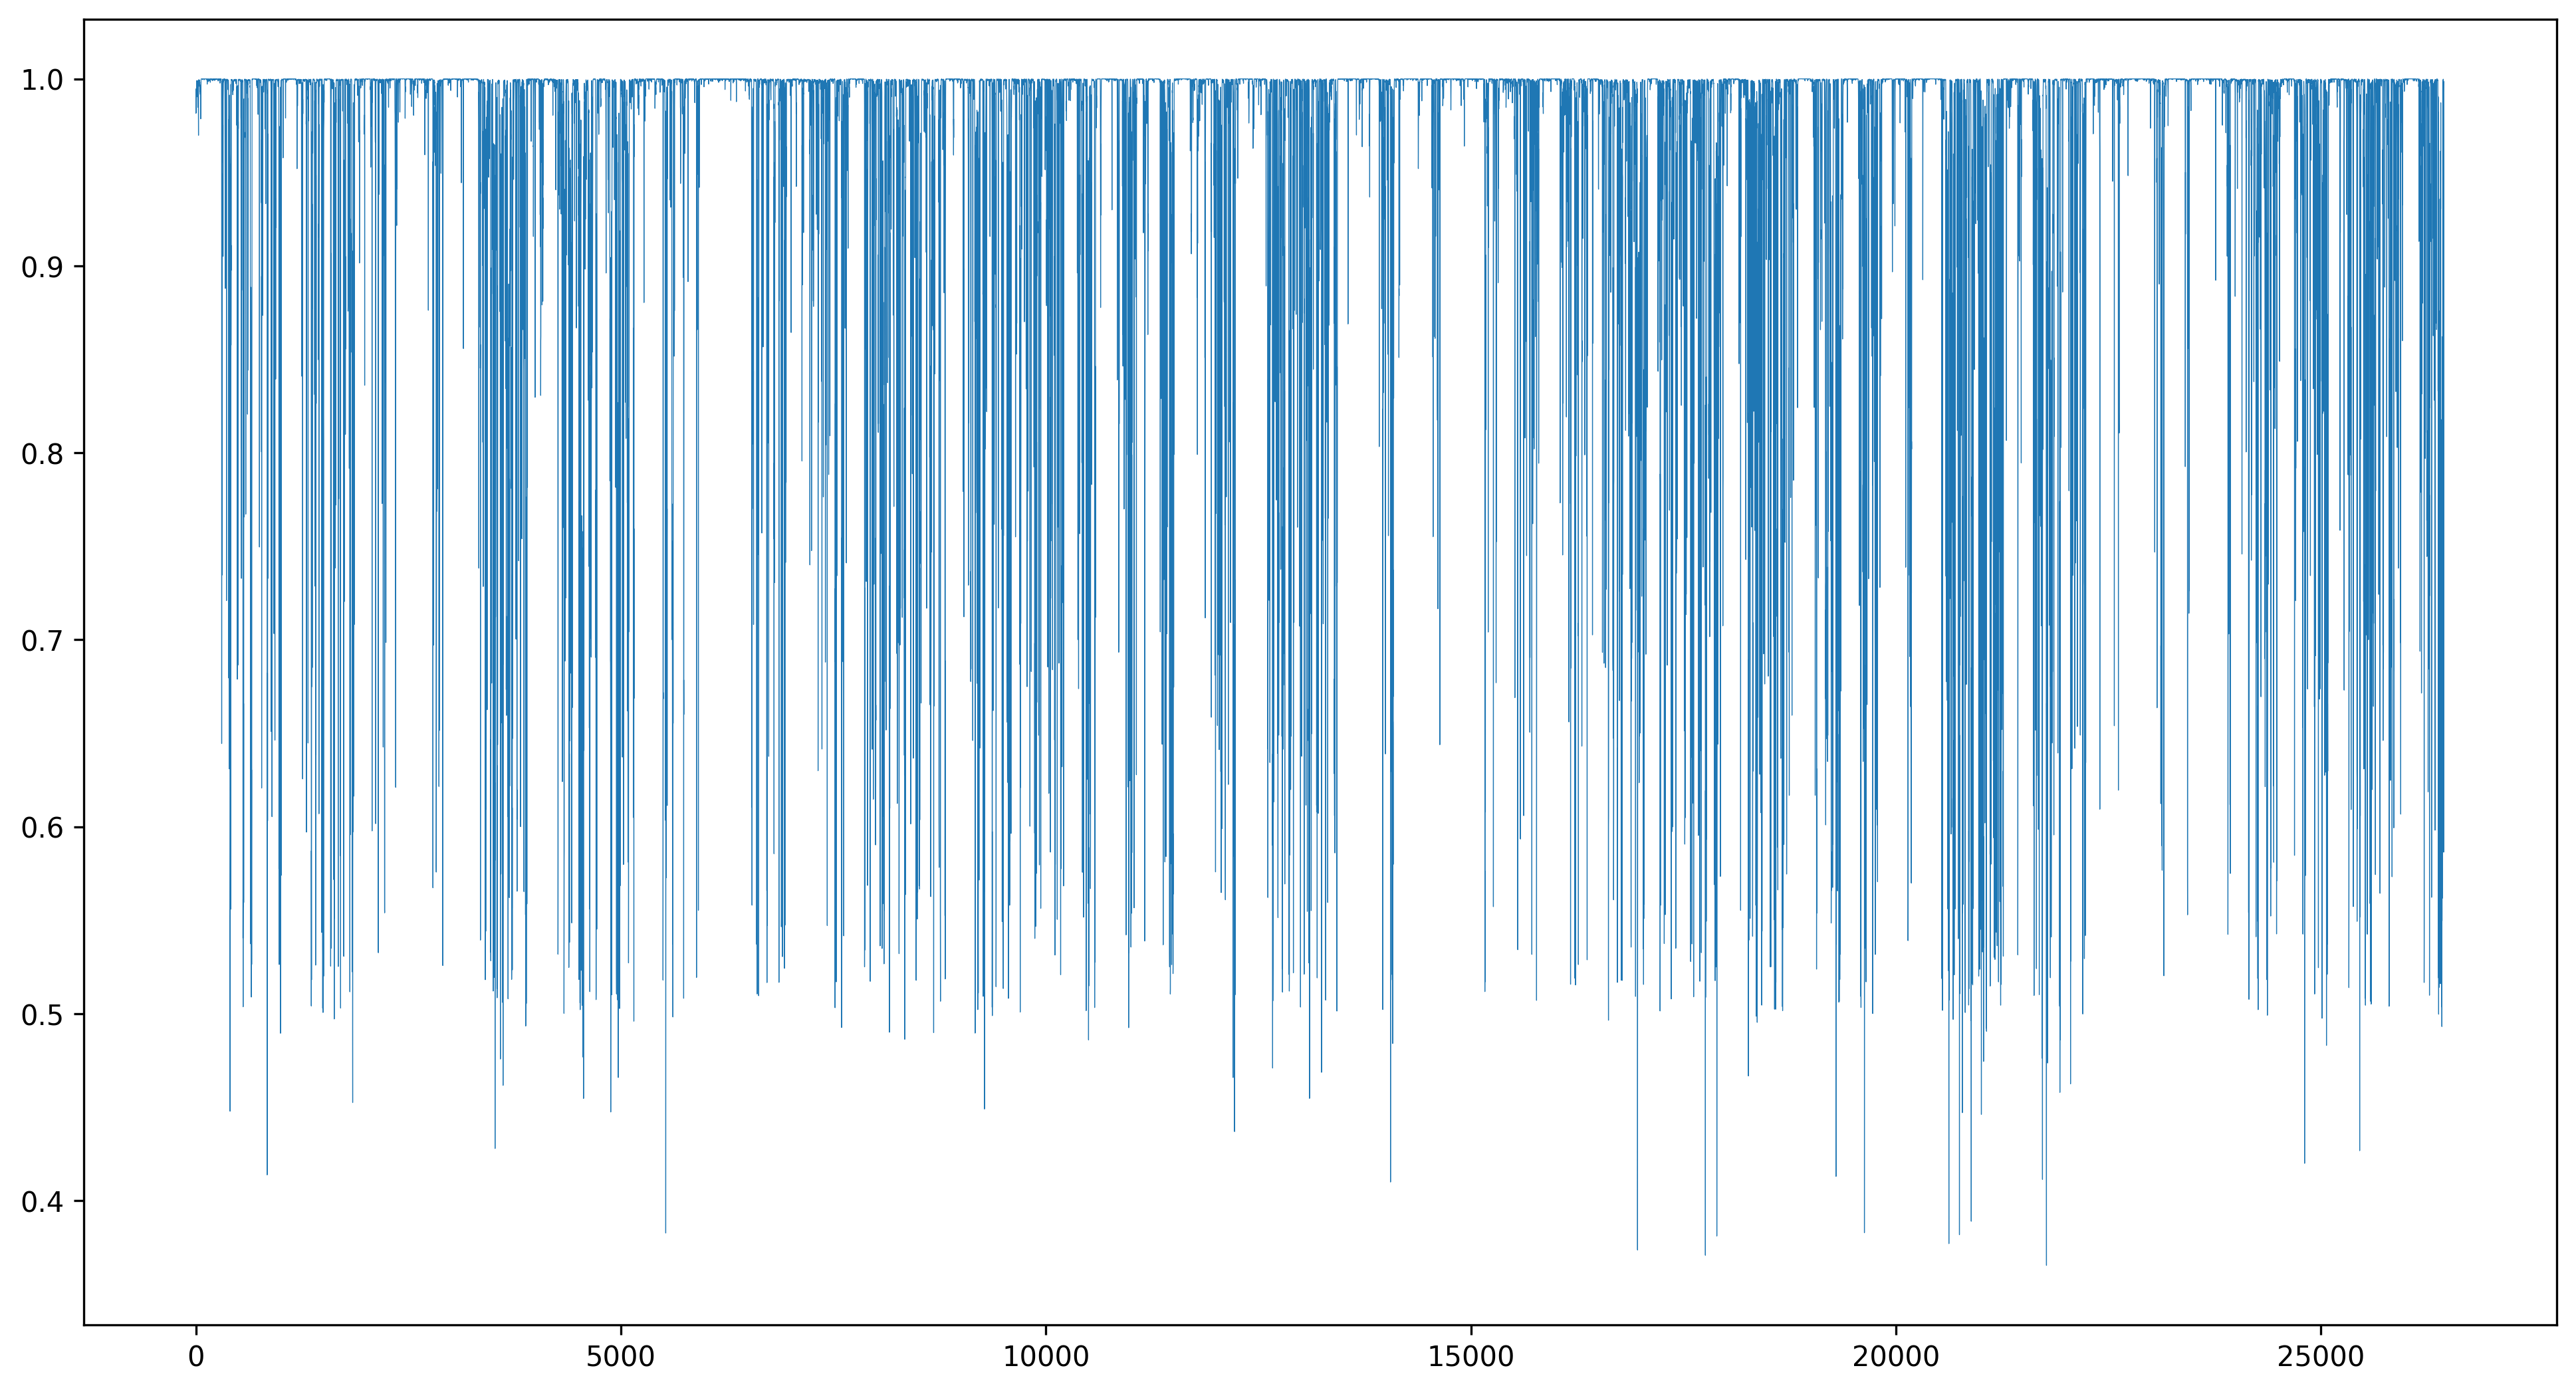

In [ ]:
# TODO: compare to underlying distribution
# TODO: confidence on hypnogram
# TODO: check EEG scale
# TODO: check whether channel is EEG at all or EMG

In [ ]:
import torch
import os
import seaborn as sns
population_data_dir = f'/media/andrew/T7/sleep/data/pt_ekyn'
X,y1 = torch.load(f'{population_data_dir}/{os.listdir(population_data_dir)[0]}')
y1 = y1.argmax(axis=1)

X,y2 = torch.load(f'{population_data_dir}/{os.listdir(population_data_dir)[2]}')
y2 = y2.argmax(axis=1)

f_exp = (y1.bincount()/len(y1))*len(y2)
f_obs = y2.bincount()

print(f_obs,f_exp)

from scipy.stats import chisquare
chisquare(f_exp=f_exp,f_obs=f_obs)

import pandas as pd
df = pd.DataFrame(torch.vstack([y1.bincount(),y2.bincount()]))
df['Group'] = [0,1]
df = df.melt(id_vars='Group')
sns.barplot(df,x='variable',y='value',hue='Group')

tensor([ 310, 4276, 4054]) tensor([ 571., 3676., 4393.])


/tmp/ipykernel_97684/3885766881.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X,y1 = torch.load(f'{population_data_dir}/{os.listdir(population_data_dir)[0]}')
/tmp/ipy

Power_divergenceResult(statistic=np.float64(243.39378860015108), pvalue=np.float64(1.4051100520914567e-53))